In [1]:
import pandas as pd
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
data = pd.DataFrame(obs_angle, columns=["rt", "response"])
data

,rt,response
0,1.131993,1.0
1,1.323992,1.0
2,6.703719,1.0
3,0.816997,1.0
4,1.350993,1.0
...,...,...
995,1.077994,1.0
996,5.056838,1.0
997,2.156031,-1.0
998,4.433883,1.0


In [3]:
import hddm_wfpt
import bambi as bmb
# Define a function with fun(data, *) signature
def my_blackbox_loglik(data, v, a, z, t, err=1e-8):
    
    data = data[:, 0] * data[:, 1]
    # print(v.shape)
    # print(v)
    # print(a.shape)
    # print(a)
    # print(z)
    # print(t)
    # print(data)
    # print(data.shape[0])

    v_ = np.zeros(data.shape[0])
    v_[:] = np.float64(v)
    a_ = np.zeros(data.shape[0])
    a_[:] = 2 * np.float64(a)
    z_ = np.zeros(data.shape[0])
    z_[:] = np.float64(z)
    t_ = np.zeros(data.shape[0])
    t_[:] = np.float64(t)
 
    # Our function expects inputs as float64, but they are not guaranteed to
    # come in as such --> we type convert

    out_logp = hddm_wfpt.wfpt.wiener_logp_array(np.float64(data),
                                            v_, # v
                                            np.zeros(data.shape[0]), # sv
                                            a_, # a
                                            z_, # z
                                            np.zeros(data.shape[0]), # sz
                                            t_, # t
                                            np.zeros(data.shape[0]), # st
                                            err,
                                            )
    
    # print(out_logp)
    return out_logp

# Create the model with pdf_ddm_blackbox
model = hssm.HSSM(
    data=data,
    model="ddm",
    loglik=my_blackbox_loglik,
    loglik_kind="blackbox",
    model_config={
        "bounds": {
            "v": (-10.0, 10.0),
            "a": (0.0, 4.0),
            "z": (0.0, 1.0),
            "t": (0.0, 2.0)
        }
    },
    t=bmb.Prior("Uniform", lower=0.0, upper=2.0, initval=0.1)
)

sample = model.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [a]
>Slice: [t]
>Slice: [z]
>Slice: [v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


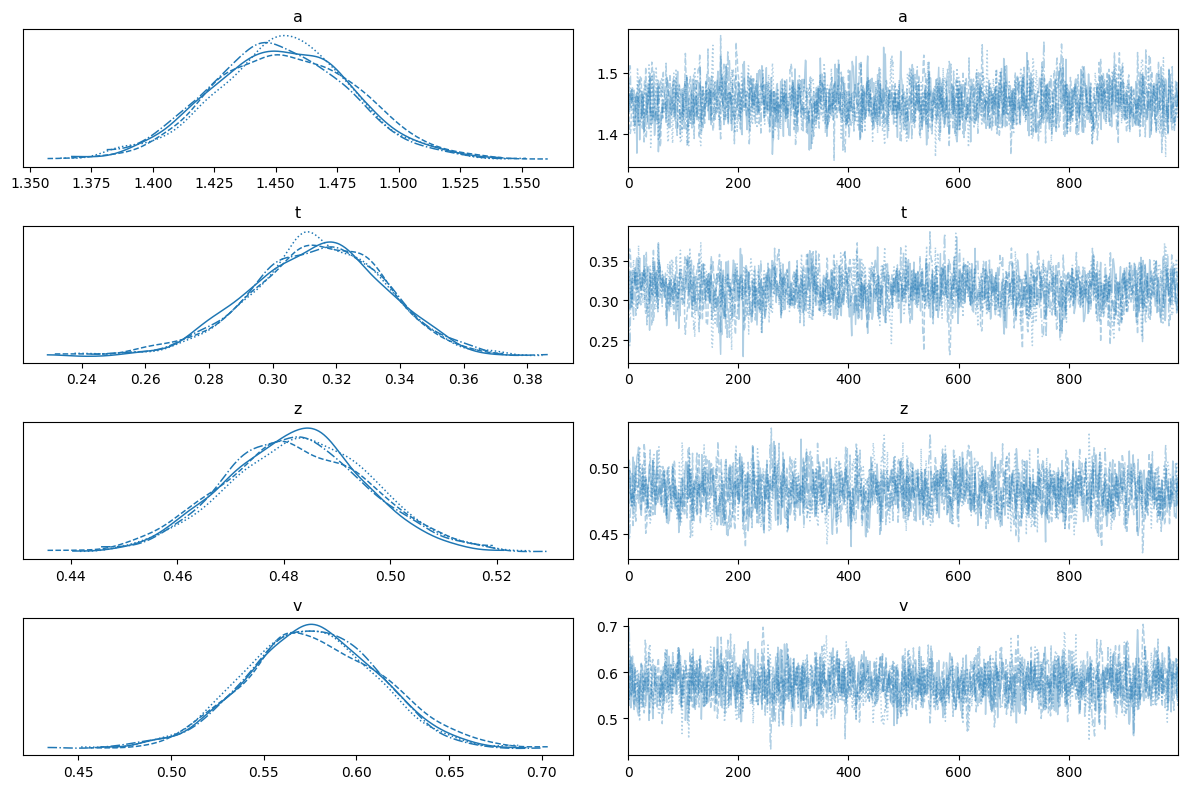

In [7]:
from matplotlib import pyplot as plt
az.plot_trace(model.traces)
plt.tight_layout()